<a href="https://colab.research.google.com/github/tleyden/FruitPunch_AI_Bootcamp/blob/main/FruitPunch_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pip installs

In [49]:
!apt install -y jq
!pip install pycocotools
!python -m pip install pyyaml==5.1


Reading package lists... Done
Building dependency tree       
Reading state information... Done
jq is already the newest version (1.5+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 14.0 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=94f6350890c0ac8ff8e0939611797b009f6950298a0e3e938e44a1b9b3de8629
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      S

## Imports

In [64]:
import os
from matplotlib import pyplot as plt
import cv2

from pycocotools.coco import COCO
import skimage.io as io
from pathlib import Path

import sys, distutils.core
from google.colab.patches import cv2_imshow


## Authenticate with google drive and mount it

In [1]:
from google.colab import auth
auth.authenticate_user()

In [3]:
# Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Copy annotations from gdrive to local dir

In [24]:
!cp -r "/content/drive/MyDrive/Projects/FruitPunchAI/Toy challenges/Poacher detection/Labeled data/annotations" .

In [25]:
!ls annotations

instances_test.json  instances_train.json  instances_val.json


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libjq1 libonig4
The following NEW packages will be installed:
  jq libjq1 libonig4
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 276 kB of archives.
After this operation, 930 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libonig4 amd64 6.7.0-1 [119 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libjq1 amd64 1.5+dfsg-2 [111 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 jq amd64 1.5+dfsg-2 [45.6 kB]
Fetched 276 kB in 0s (649 kB/s)
Selecting previously unselected package libonig4:amd64.
(Reading database ... 124013 files and directories currently installed.)
Preparing to unpack .../libo

## Download zips from google bucket

In [30]:
source_dirs = ["Labeled data-20211126T095740Z-001.zip", "Labeled data-20211126T095740Z-002.zip"]
for source_dir in source_dirs:
    if not os.path.exists(source_dir):
        !gsutil cp {source_dir} .

In [32]:
!unzip "Labeled data-20211126T095740Z-001.zip"
!unzip "Labeled data-20211126T095740Z-002.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Labeled data/images/train/videobh_1_000230.PNG  
  inflating: Labeled data/images/train/video53_9_000162.PNG  
  inflating: Labeled data/images/train/videobh_1_003456.PNG  
  inflating: Labeled data/images/train/videobh_1_002075.PNG  
  inflating: Labeled data/images/train/videobh_2_000593.PNG  
  inflating: Labeled data/images/train/videobh_1_000905.PNG  
  inflating: Labeled data/images/train/videobh_1_003138.PNG  
  inflating: Labeled data/images/train/video53_1_001716.PNG  
  inflating: Labeled data/images/train/video53_1_000897.PNG  
  inflating: Labeled data/images/train/video53_2_002344.PNG  
  inflating: Labeled data/images/train/video78_1_001157.PNG  
  inflating: Labeled data/images/train/video78_1_001110.PNG  
  inflating: Labeled data/images/train/video53_9_000330.PNG  
  inflating: Labeled data/images/train/videobh_1_002617.PNG  
  inflating: Labeled data/images/train/videobh_3_000573.PNG  
  inflating: Labele

## Re-arrange directories to match expected structure

In [33]:
!mv "Labeled data" labeled_data

In [34]:
!mkdir labeled_data/images/test 
!mv labeled_data/images/*.PNG labeled_data/images/test 

## Set path variables

In [57]:
DATA_PATH = '/content/labeled_data/'
IMAGES_PATH = DATA_PATH + 'images/'
LABELS_PATH = DATA_PATH + 'annotations/'

# Get paths to IMAGE directories
TRAIN_IMAGES_PATH = IMAGES_PATH + 'train/'
TEST_IMAGES_PATH = IMAGES_PATH + 'test/'
VAL_IMAGES_PATH = IMAGES_PATH + 'val/'

TRAIN_LABELS = LABELS_PATH + 'instances_train.json'
TEST_LABELS = LABELS_PATH + 'instances_test_dataset.json'
VAL_LABELS = LABELS_PATH + 'instances_val.json'

## Step 1 - analyze the data

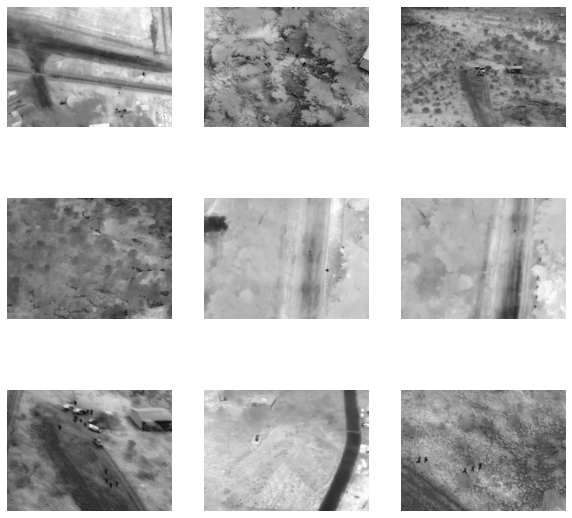

In [40]:
# View some train images
plt.figure(figsize=(10, 10))
TRAIN_IMAGES = os.listdir(TRAIN_IMAGES_PATH)
for i in range(9):
  img_path = TRAIN_IMAGES_PATH + TRAIN_IMAGES[i]
  ax = plt.subplot(3, 3, i + 1)
  img = cv2.imread(img_path, )
  plt.imshow(img, cmap='gray')
  plt.axis("off")

In [47]:
# Analyse training annotations
coco = COCO(TRAIN_LABELS) # return dictionary of the dataset
img_IDs = coco.getImgIds() # get image IDs
imgs = coco.loadImgs(img_IDs[1100:1103]) # load images

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


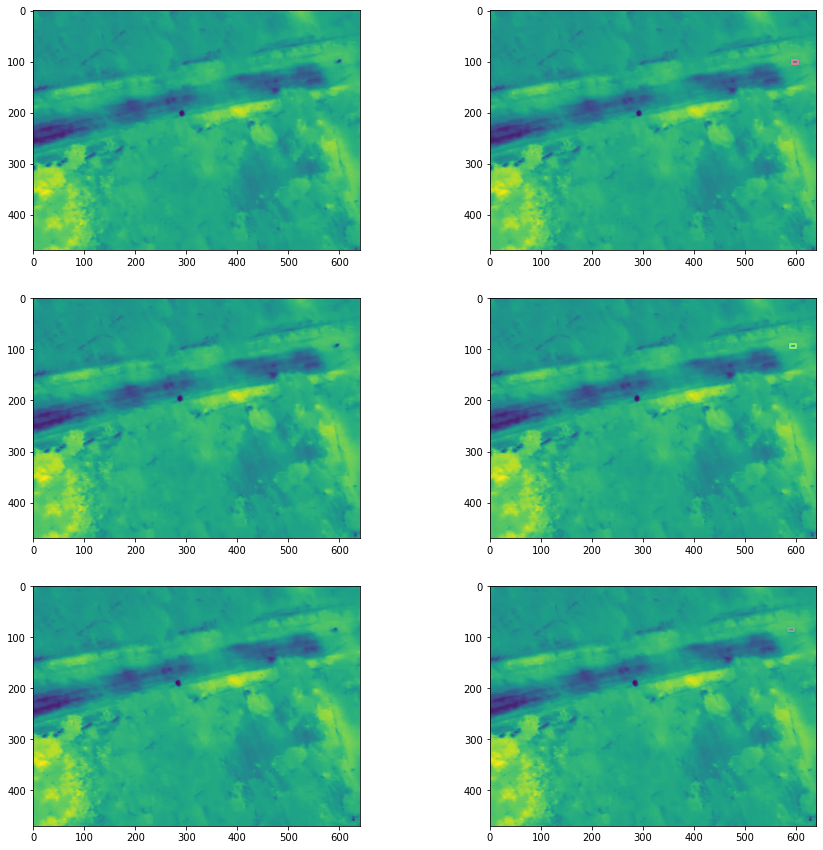

In [48]:

# Visualise images and annotations
_, axs = plt.subplots(len(imgs), 2, figsize=(15, 15))
for img, ax in zip(imgs, axs):
    I = io.imread(Path(TRAIN_IMAGES_PATH)/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

## Step 2 - model

### Install detectron2

In [51]:
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Cloning into 'detectron2'...
remote: Enumerating objects: 14641, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 14641 (delta 19), reused 35 (delta 14), pack-reused 14584
Receiving objects: 100% (14641/14641), 6.00 MiB | 12.37 MiB/s, done.
Resolving deltas: 100% (10569/10569), done.


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.3 MB/s 
     |████████████████████████████████| 79 kB 8.4 MB/s 
     |████████████████████████████████| 153 kB 68.7 MB/s 
     |████████████████████████████████| 1.5 MB 59.3 MB/s 
     |████████████████████████████████| 549 kB 92.3 MB/s 
     |████████████████████████████████| 117 kB 94.7 MB/s 
     |████████████████████████████████| 96 kB 7.0 MB/s 
     |████████████████████████████████| 182 kB 80.4 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221122-py3-none-any.whl size=61484 sha256=5922d794de241665001ccadb6461d98c696178fd244f719e5cdbb9ff8dd128f8
  Stored in directory: /root/.cache/pip/wheels/15/6e/e3/602889ca9c5c55020f8d205066445ac5b1b96df59f75170ca0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=5a09f8b6115983640122bb9e258039064198bafcadb4bcf334b426a

### Show versions

In [52]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


### Import modules

In [54]:
# import detectron2 modules
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

import json, random
from detectron2.data.datasets import register_coco_instances


### Register coco instances

In [55]:
register_coco_instances("my_dataset_train", {}, TRAIN_LABELS, TRAIN_IMAGES_PATH)
register_coco_instances("my_dataset_test", {}, TEST_LABELS, TEST_IMAGES_PATH)
register_coco_instances("my_dataset_val", {}, VAL_LABELS, VAL_IMAGES_PATH)

### Get dictionary of filenames and image ids

In [ ]:

# get dictionary of filename and image ids
def get_filenames(filename_dict, json_file):
    with open(json_file) as f:
      imgs_anns = json.load(f)
    for idx in imgs_anns["images"]:
      filename = idx["file_name"]
      img_id = idx["id"]
      filename_dict[img_id] = filename
    return filename_dict

filename_dict = {}
get_filenames(filename_dict, TRAIN_LABELS)
get_filenames(filename_dict, TEST_LABELS)
get_filenames(filename_dict, VAL_LABELS)

### Visualize training data

[12/13 00:02:18 d2.data.datasets.coco]: Loaded 13111 images in COCO format from /content/labeled_data/annotations/instances_train.json


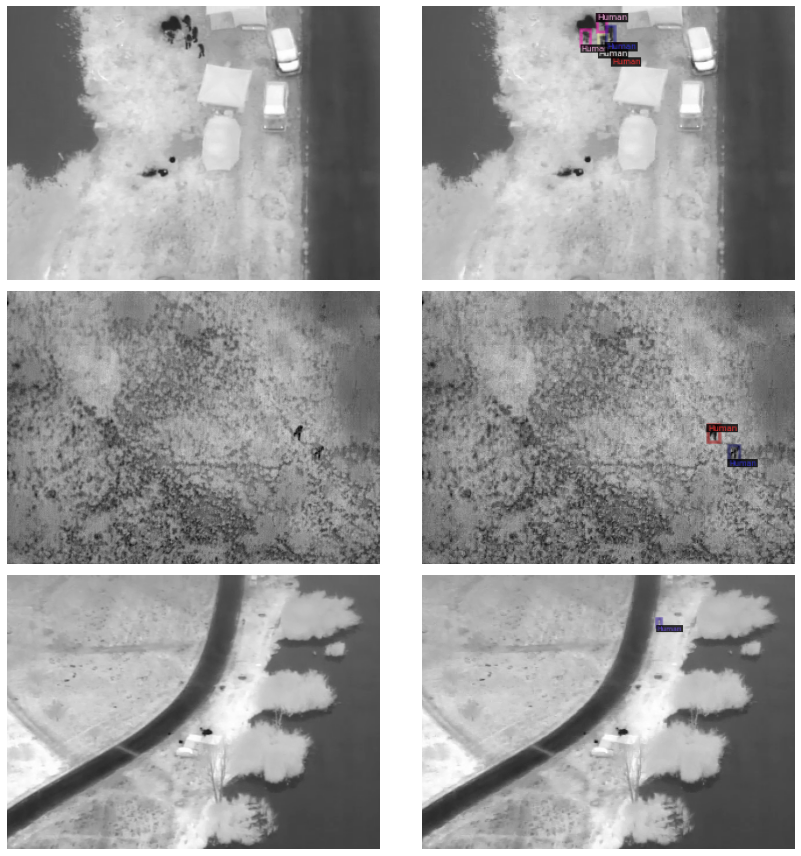

In [65]:

# visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

_, axs = plt.subplots(len(imgs), 2, figsize=(12, 12))
for d, ax in zip(random.sample(dataset_dicts, 3), axs):
    id = d["image_id"]
    filename = filename_dict[id]
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    # cv2_imshow(vis.get_image()[:, :, ::-1])
    ax[0].imshow(img); ax[0].axis('off')
    ax[1].imshow(vis.get_image()[:, :, ::-1]); ax[1].axis('off')
    plt.tight_layout()

## Training

fine-tune a COCO-pretrained model on the custom dataset


### Create config

In [66]:
from detectron2.engine import DefaultTrainer

pretrained_model = "faster_rcnn_R_50_FPN_1x.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(f"COCO-Detection/{pretrained_model}"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"COCO-Detection/{pretrained_model}")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.TEST.EVAL_PERIOD = 500

### Define cocotrainer

In [67]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

### Run training

In [68]:

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

RuntimeError: ignored